In [1]:
import gpflow
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

from models.GPMove import GPMove

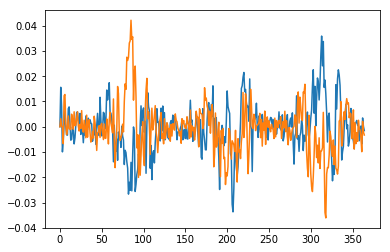

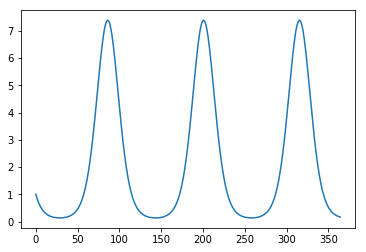

In [2]:
df = pd.read_csv('switch_lengthscale_only.csv',index_col=0)
X = df[['Latitude','Longitude']].values
L = df['Lengthscale'].values
T = T = (pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.days.astype(float).values
T = T-T[0]
#T = T - T.mean()
#T = T/T.std()
T=T[:,None]

plt.plot(T,X[:,0])
#plt.show()
plt.plot(T,X[:,1])
plt.show()
plt.plot(T,L)
plt.show()

In [3]:
#create model 
with gpflow.defer_build():
    kl = gpflow.kernels.RBF(1, ARD=False, lengthscales=100, variance=0.1) #+ gpflow.kernels.Bias(1)
    kv = gpflow.kernels.RBF(1, ARD=False, lengthscales=100, variance=1) #+ gpflow.kernels.Bias(1)
    m = GPMove(T, X, kl, kv)

In [4]:
# set priors
m.kern_len.lengthscales.prior = gpflow.priors.Gaussian(50.0, 100.00)
m.kern_len.variance.prior = gpflow.priors.Gaussian(50.00,100.00)
m.kern_var.lengthscales.prior = gpflow.priors.Gaussian(50.0, 100.00)
m.kern_var.variance.prior = gpflow.priors.Gaussian(50.00,100.00)

In [5]:
# compile and set parameters to MAP
m.compile()
gpflow.train.ScipyOptimizer().minimize(m)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -2035.985817
  Number of iterations: 1000
  Number of functions evaluations: 1077


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: -2035.985817
  Number of iterations: 1000
  Number of functions evaluations: 1077


,class,prior,transform,trainable,shape,fixed_shape,value
GPMove/V_len,Parameter,"N(0.0,1.0)",(none),True,"(365, 1)",True,"[[-0.06870447796984488], [0.17717484861578847]..."
GPMove/V_var,Parameter,"N(0.0,1.0)",(none),True,"(365, 1)",True,"[[-1.1065647055126924], [-0.5178994169296924],..."
GPMove/kern_len/lengthscales,Parameter,"N(50.0,100.0)",+ve,True,(),True,23.144367290394804
GPMove/kern_len/variance,Parameter,"N(50.0,100.0)",+ve,True,(),True,58.0322348369462
GPMove/kern_var/lengthscales,Parameter,"N(50.0,100.0)",+ve,True,(),True,30.724831374216105
GPMove/kern_var/variance,Parameter,"N(50.0,100.0)",+ve,True,(),True,74.03985851520015
GPMove/likelihood/variance,Parameter,None,+ve,True,(),True,1.0000223545626452e-06


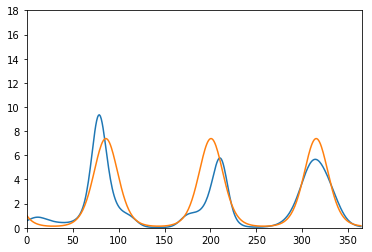

In [6]:

ls=m.predict_length()
plt.plot(ls)
plt.plot(L)
plt.axis([0,365,0,18])
plt.show()

In [7]:
# HMC sampling
s = gpflow.train.HMC()
samples = s.sample(m, 100, epsilon=0.02, lmax=20, lmin=18, thin=5, logprobs=True)#
print('acceptance rate: ', len(set(samples.logprobs))/len(samples.logprobs))
samples = samples.drop('logprobs', axis=1)

acceptance rate:  0.95


In [8]:
# set values to HMC sample value and predict lengthscale
f_samples = np.zeros((len(samples),len(T)))

for i, s in samples.iterrows():  # also possible as arguments to hmc.sample()
    feed_dict = m.sample_feed_dict(s)
    f_samples[i,:] =m.predict_length(feed_dict=feed_dict)[:,0]

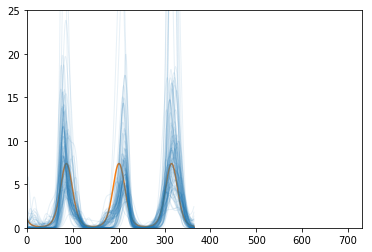

In [9]:
# plot each sample
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(L,color=cycle[1])
for i in range(len(samples)):
    plt.plot(T, f_samples[i,:], color=cycle[0],lw=1,alpha=0.1)
plt.axis([0,2*365,0,25])
plt.show()

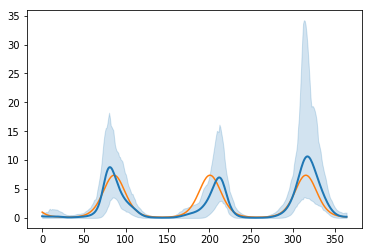

In [10]:
#plot confidence intervals
rate_samples = (f_samples[:,:])
plt.plot(L,color=cycle[1])
line, = plt.plot(T, np.mean(rate_samples, 0), color=cycle[0],lw=2)
plt.fill_between(T[:,0],
                 np.squeeze(np.percentile(rate_samples, 5, axis=0)),
                 np.squeeze(np.percentile(rate_samples, 95, axis=0)),
                 color=line.get_color(), alpha = 0.2)
plt.show()

#plt.plot(T,X[:,0])
#plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))

In [11]:
# set values to HMC sample value and predict lengthscale
maxT = np.max(T)
xx = T#np.linspace(0,maxT, 2000).reshape(-1,1)
y_samples = []
for i, s in samples.iterrows():  # also possible as arguments to hmc.sample()
    feed_dict = m.sample_feed_dict(s)
    my, vy = m.predict_y(xx,feed_dict=feed_dict)
    y_samples.append(my)

In [12]:
# set values to HMC sample value and predict lengthscale
maxT = np.max(T)
xx = T#np.linspace(0,maxT, 2000).reshape(-1,1)
y_samples = []
for i, s in samples.iterrows():  # also possible as arguments to hmc.sample()
    feed_dict = m.sample_feed_dict(s)
    my, vy = m.predict_y(xx,feed_dict=feed_dict)
    y_samples.append(my)

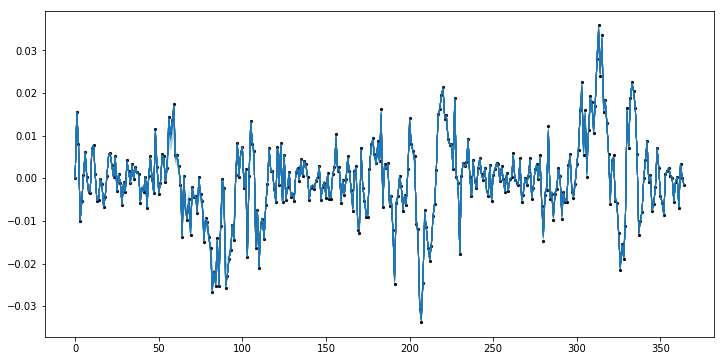

In [13]:
# plot each sample
matplotlib.rcParams['figure.figsize'] = (12, 6)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(T, X[:,0], 'k.', mew=0.2)
for i in range(len(y_samples)):
    plt.plot(T, y_samples[i][:,0], color=cycle[0],lw=1,alpha=0.1)
#plt.axis([0,100,-2,2])
plt.show()

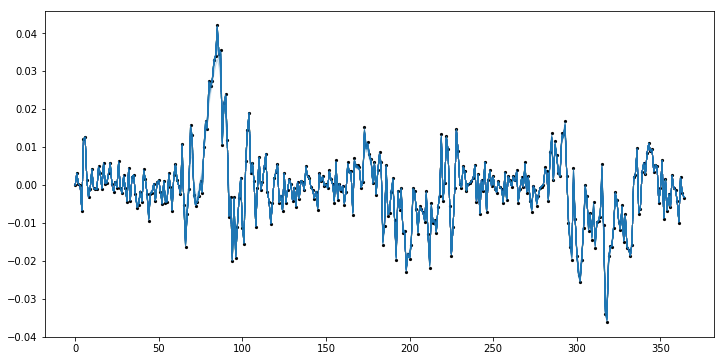

In [14]:
# plot each sample
matplotlib.rcParams['figure.figsize'] = (12, 6)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(T, X[:,1], 'k.', mew=0.2)
for i in range(len(y_samples)):
    plt.plot(T, y_samples[i][:,1], color=cycle[0],lw=1,alpha=0.1)
#plt.axis([0,100,-2,2])
plt.show()

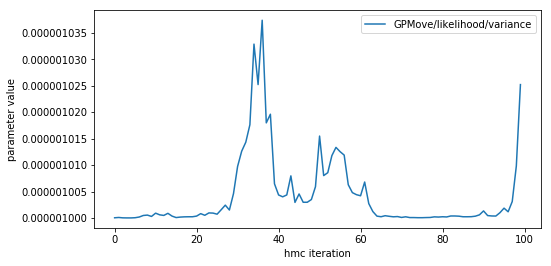

In [15]:
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    
    if col.name=='GPMove/likelihood/variance':
        plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')
plt.show()